In [2]:
import requests
import tensorflow as tf
import numpy as np
import os
from matplotlib.image import imread, imsave 
import matplotlib.pyplot as plt  
import pandas as pd
from konlpy.tag import Mecab
from gensim.models import word2vec
print("load done")

load done


# Parameters

In [15]:
vector_size = 50
encode_length = 6
label_size = 10
embed_type = "onehot" #onehot or w2v
# Choose single test
filter_type = "single"
filter_number = 32
filter_size = 2

# Choose multi test
# filter_type = "multi"
# filter_sizes = [2,3,4,2,3,4,2,3,4]
num_filters = len(filter_sizes)

# Vector model

In [4]:
def train_vector_model(path):
    with open (path, "r") as myfile : 
        str_buf = myfile.readlines()

    mecab = Mecab('/usr/local/lib/mecab/dic/mecab-ko-dic')
    pos1 = mecab.pos(''.join(str_buf))
    pos2 = ' '.join(list(map(lambda x : '\n' if x[1] in ['SF'] else x[0], pos1))).split('\n')
    morphs = list(map(lambda x : mecab.morphs(x) , pos2))
    model = word2vec.Word2Vec(size=vector_size, window=2, min_count=1)
    model.build_vocab(morphs)
    model.train(morphs)
    return model

model = train_vector_model("./data/train.txt")

# Load Train Data

In [5]:
def load_csv(data_path):
    df_csv_read = pd.read_csv(data_path,
                              skipinitialspace=True,
                              engine="python",
                              encoding='utf-8-sig')
    return df_csv_read

# Embed word to vector

In [6]:
def embed(data) : 
    mecab = Mecab('/usr/local/lib/mecab/dic/mecab-ko-dic')
    inputs = []
    labels = []
    
    for encode_raw in data['encode'] : 
        encode_raw = mecab.morphs(encode_raw)
        encode_raw = list(map(lambda x : encode_raw[x] if x < len(encode_raw) else '#', range(encode_length)))
        if(embed_type == 'onehot') :
            bucket = np.zeros(vector_size, dtype=float).copy()
            input = np.array(list(map(lambda x : onehot_vectorize(bucket, x) if x in model.wv.index2word else np.zeros(vector_size,dtype=float) , encode_raw)))
        else : 
            input = np.array(list(map(lambda x : model[x] if x in model.wv.index2word else np.zeros(vector_size,dtype=float) , encode_raw)))
     
        inputs.append(input.flatten())
        
    for decode_raw in data['decode'] : 
        label = np.zeros(label_size, dtype=float)
        np.put(label, decode_raw, 1)
        labels.append(label)
    
    return inputs, labels

def onehot_vectorize(bucket, x):
    np.put(bucket, model.wv.index2word.index(x),1)
    return bucket
    

# Embed word to vector on predict step

In [7]:
def inference_embed(data) : 
    mecab = Mecab('/usr/local/lib/mecab/dic/mecab-ko-dic')
    encode_raw = mecab.morphs(data)
    encode_raw = list(map(lambda x : encode_raw[x] if x < len(encode_raw) else '#', range(encode_length)))
    if(embed_type == 'onehot') :
        bucket = np.zeros(vector_size, dtype=float).copy()
        input = np.array(list(map(lambda x : onehot_vectorize(bucket, x) if x in model.wv.index2word else np.zeros(vector_size,dtype=float) , encode_raw)))
    else : 
        input = np.array(list(map(lambda x : model[x] if x in model.wv.index2word else np.zeros(vector_size,dtype=float) , encode_raw)))
    return input

# get train and test data for feed on tensorflow session

In [8]:
def get_test_data() :
    train_data, train_label = embed(load_csv("./data/train.csv"))
    test_data, test_label = embed(load_csv("./data/test.csv"))
    return train_label, test_label, train_data, test_data

# create graph with single filter size

In [9]:
def create_s_graph(train=True):
    # placeholder is used for feeding data.
    x = tf.placeholder("float", shape=[None, encode_length * vector_size], name = 'x') 
    y_target = tf.placeholder("float", shape=[None, label_size], name = 'y_target') 

    # reshape input data
    x_image = tf.reshape(x, [-1,encode_length,vector_size,1], name="x_image")
    
    # Build a convolutional layer and maxpooling with random initialization
    W_conv1 = tf.Variable(tf.truncated_normal([filter_size, filter_size, 1, filter_number], stddev=0.1), name="W_conv1") # W is [row, col, channel, feature]
    b_conv1 = tf.Variable(tf.zeros([filter_number]), name="b_conv1")
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1, name="h_conv1")
    h_pool1 = tf.nn.max_pool( h_conv1 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "h_pool1")
    
    # Build a fully connected layer
    h_pool2_flat = tf.reshape(h_pool1, [-1, int((encode_length/2)*(vector_size/2))*filter_number], name="h_pool2_flat")
    W_fc1 = tf.Variable(tf.truncated_normal([int((encode_length/2)*(vector_size/2))*filter_number, 256], stddev=0.1), name = 'W_fc1')
    b_fc1 = tf.Variable(tf.zeros([256]), name = 'b_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name="h_fc1")
    
    keep_prob = 1.0
    if(train) : 
        # Dropout Layer
        keep_prob = tf.placeholder("float", name="keep_prob")
        h_fc1 = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")
    
    # Build a fully connected layer with softmax 
    W_fc2 = tf.Variable(tf.truncated_normal([256, label_size], stddev=0.1), name = 'W_fc2')
    b_fc2 = tf.Variable(tf.zeros([label_size]), name = 'b_fc2')
    #y=tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name="y")
    y=tf.matmul(h_fc1, W_fc2) + b_fc2
    
    # define the Loss function
    #cross_entropy = -tf.reduce_sum(y_target*tf.log(y), name = 'cross_entropy')
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_target))
    
    # define optimization algorithm
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_target, 1))
    # correct_prediction is list of boolean which is the result of comparing(model prediction , data)

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
    # tf.cast() : changes true -> 1 / false -> 0
    # tf.reduce_mean() : calculate the mean
    
    return accuracy, x, y_target, keep_prob, train_step, y, cross_entropy, W_conv1
    
print("define cnn graph func")

define cnn graph func


# create graph with multi filter size

In [10]:
def create_m_graph(train=True):
    # placeholder is used for feeding data.
    x = tf.placeholder("float", shape=[None, encode_length * vector_size], name = 'x') 
    y_target = tf.placeholder("float", shape=[None, label_size], name = 'y_target') 

    # reshape input data
    x_image = tf.reshape(x, [-1,encode_length,vector_size,1], name="x_image")
    # Keeping track of l2 regularization loss (optional)
    l2_loss = tf.constant(0.0)
    
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        with tf.name_scope("conv-maxpool-%s" % filter_size):
            # Convolution Layer
            filter_shape = [filter_size, vector_size, 1, num_filters]
            W_conv1 = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            
            conv = tf.nn.conv2d(
                x_image,
                W_conv1,
                strides=[1, 1, 1, 1],
                padding="VALID",
                name="conv")
            
            # Apply nonlinearity
            h = tf.nn.relu(tf.nn.bias_add(conv, b_conv1), name="relu")
            # Maxpooling over the outputs
            pooled = tf.nn.max_pool(
                h,
                ksize=[1, encode_length - filter_size + 1, 1, 1],
                strides=[1, 1, 1, 1],
                padding='VALID',
                name="pool")
            pooled_outputs.append(pooled)

    # Combine all the pooled features
    num_filters_total = num_filters * len(filter_sizes)
    h_pool = tf.concat(pooled_outputs, 3)
    h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
 
    # Add dropout
    keep_prob = 1.0
    if(train) : 
        keep_prob = tf.placeholder("float", name="keep_prob")
        h_pool_flat = tf.nn.dropout(h_pool_flat, keep_prob)

    # Final (unnormalized) scores and predictions
    W_fc1 = tf.get_variable(
        "W_fc1",
        shape=[num_filters_total, label_size],
        initializer=tf.contrib.layers.xavier_initializer())
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[label_size]), name="b")
    l2_loss += tf.nn.l2_loss(W_fc1)
    l2_loss += tf.nn.l2_loss(b_fc1)
    y = tf.nn.xw_plus_b(h_pool_flat, W_fc1, b_fc1, name="scores")
    predictions = tf.argmax(y, 1, name="predictions")

    # CalculateMean cross-entropy loss
    losses = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_target)
    cross_entropy = tf.reduce_mean(losses)

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    # Accuracy
    correct_predictions = tf.equal(predictions, tf.argmax(y_target, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
    
    return accuracy, x, y_target, keep_prob, train_step, y, cross_entropy, W_conv1
    
print("define cnn graph func")

define cnn graph func


# visualize weight matrix function 

In [11]:
def show_layer(weight_list) :
    if(filter_type == 'multi') : 
        show = np.array(weight_list).reshape(num_filters, filter_sizes[np.argmax(filter_sizes)], vector_size)
        for i, matrix in enumerate(show) :
            fig = plt.figure()
            plt.imshow(matrix)
        plt.show()
    else : 
        show = np.array(weight_list).reshape(32, 2, 2)
        for i, matrix in enumerate(show) :
            fig = plt.figure()
            plt.imshow(matrix)
        plt.show()

# run train 

Instructions for updating:
Please use tf.global_variables instead.
step 0, training accuracy: 0.059
step 10, training accuracy: 0.529
step 20, training accuracy: 0.882
step 30, training accuracy: 0.941
step 40, training accuracy: 0.941
step 50, training accuracy: 0.882
step 60, training accuracy: 0.882
step 70, training accuracy: 0.882
step 80, training accuracy: 0.882
step 90, training accuracy: 0.882
step 100, training accuracy: 0.882
step 110, training accuracy: 0.882
step 120, training accuracy: 0.882
step 130, training accuracy: 0.941
step 140, training accuracy: 0.941
step 150, training accuracy: 0.941
step 160, training accuracy: 1.000
step 170, training accuracy: 0.941
step 180, training accuracy: 0.941
step 190, training accuracy: 1.000
test accuracy: 1


/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


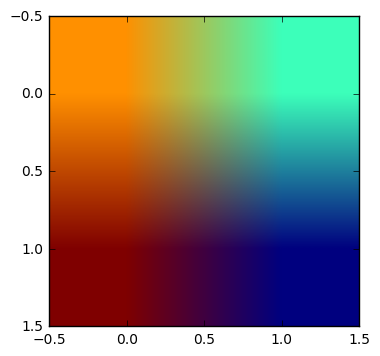

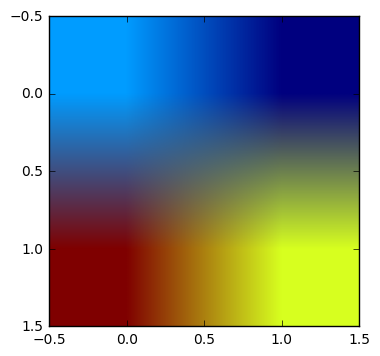

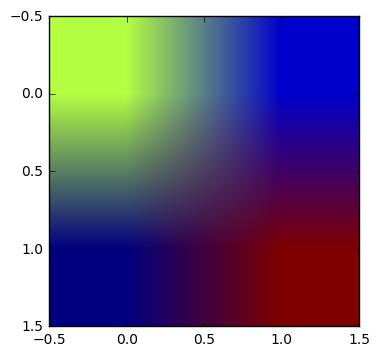

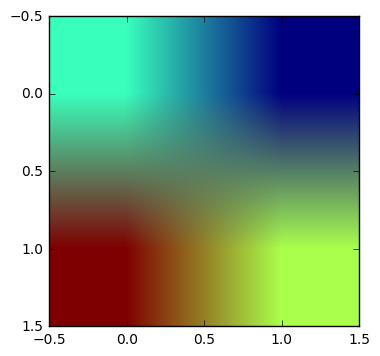

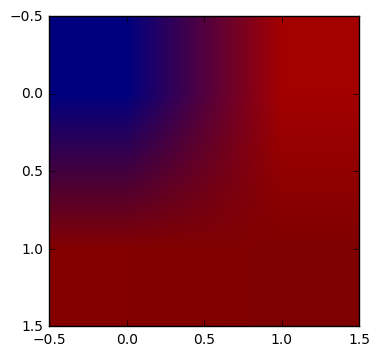

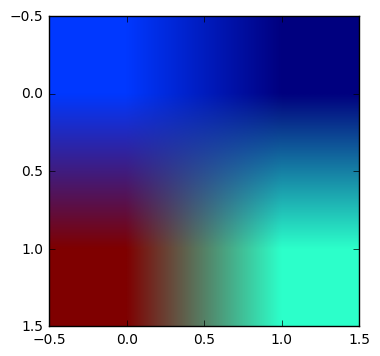

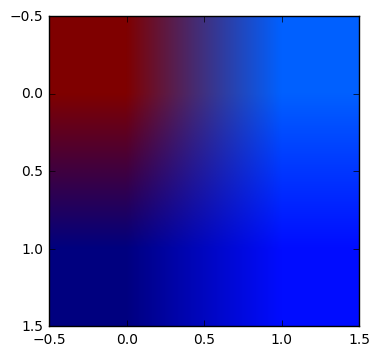

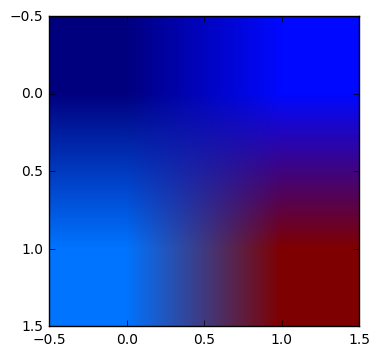

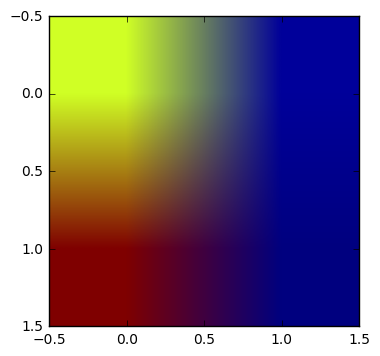

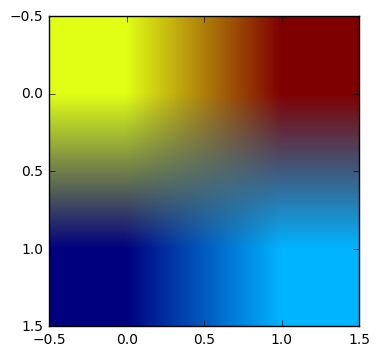

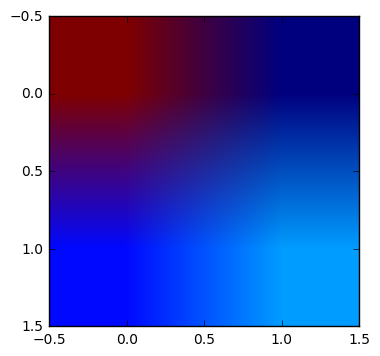

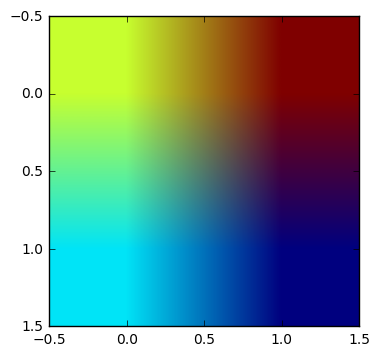

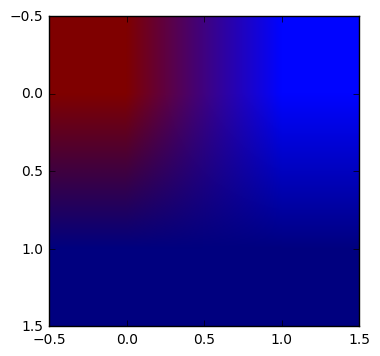

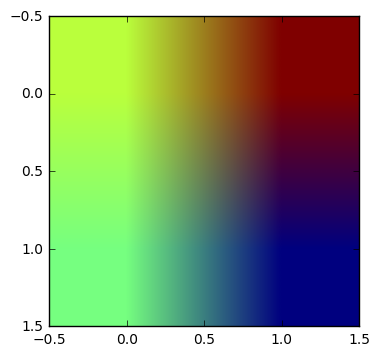

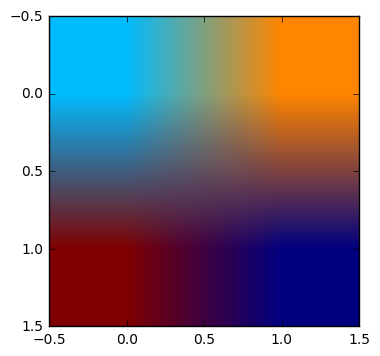

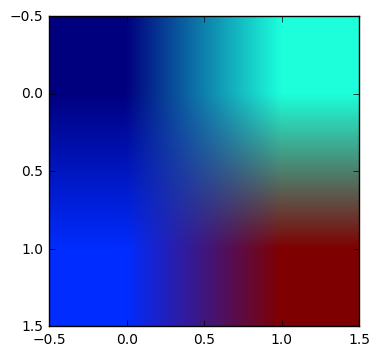

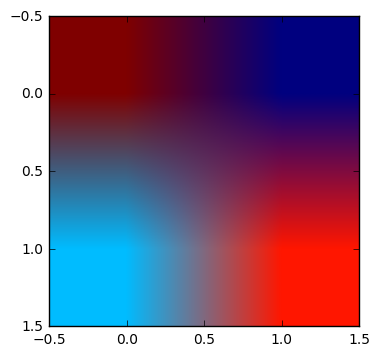

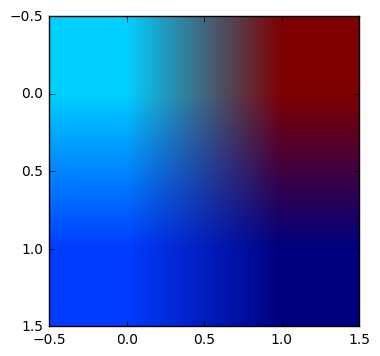

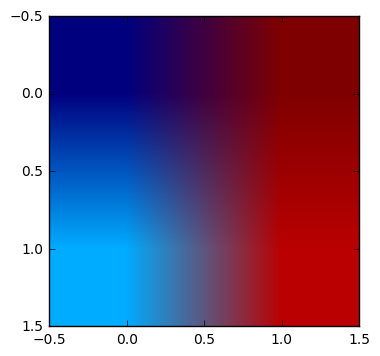

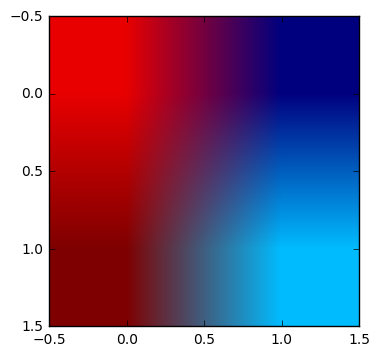

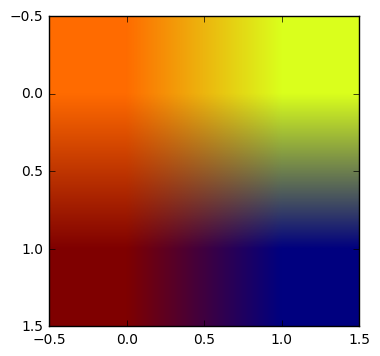

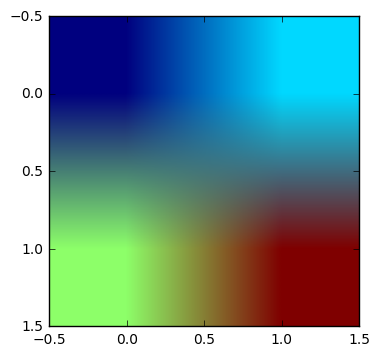

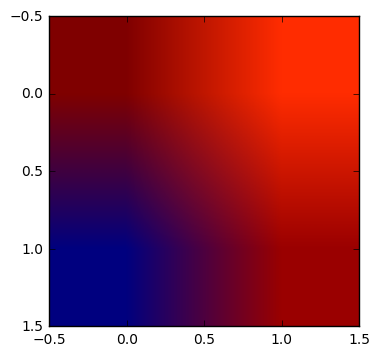

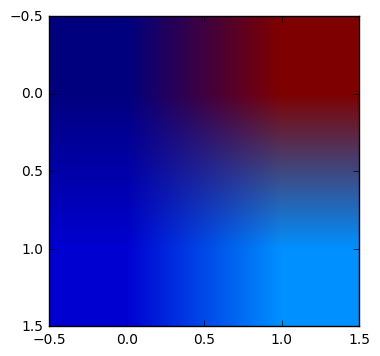

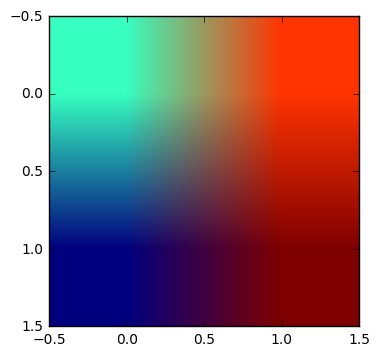

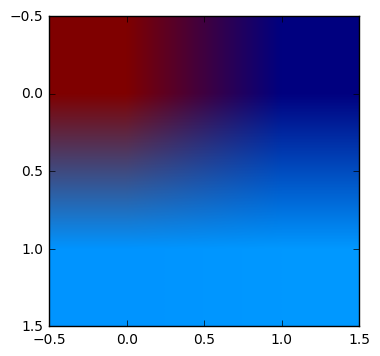

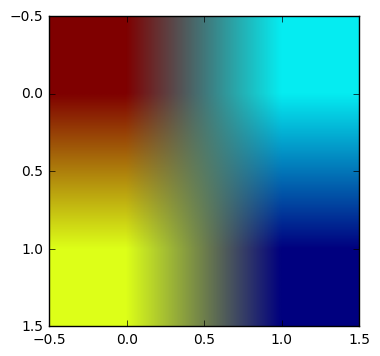

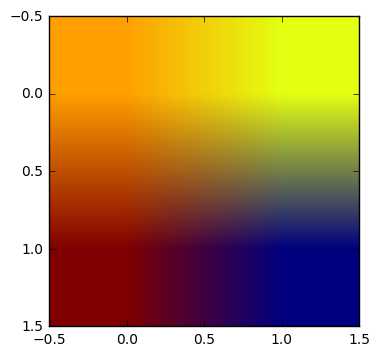

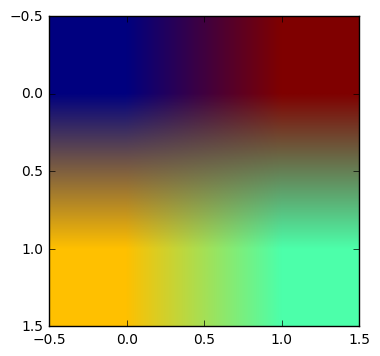

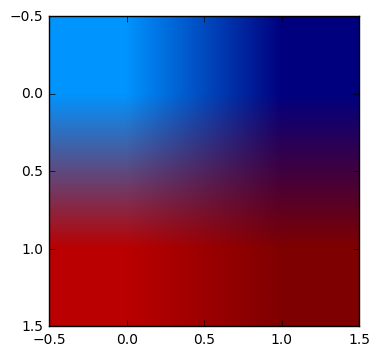

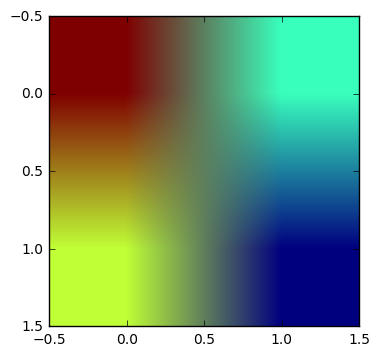

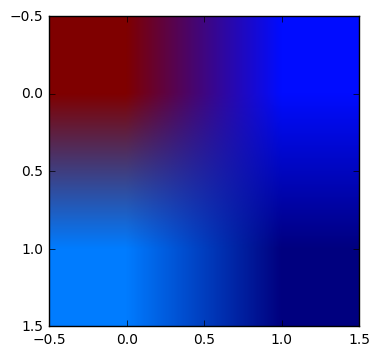

model saved


In [16]:
def run() : 
    try : 
        # get Data 
        labels_train, labels_test, data_filter_train, data_filter_test = get_test_data()
        # reset Graph
        tf.reset_default_graph()   
 
        # Create Session
        sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))  
        # create graph
        if(filter_type == 'single') :
            accuracy, x, y_target, keep_prob, train_step, y, cross_entropy, W_conv1 = create_s_graph(train=True)
        else :
            accuracy, x, y_target, keep_prob, train_step, y, cross_entropy, W_conv1 = create_m_graph(train=True)
            
        # set saver
        saver = tf.train.Saver(tf.all_variables())
        # initialize the variables
        sess.run(tf.global_variables_initializer())
    
        # training the MLP
        for i in range(200): 
            sess.run(train_step, feed_dict={x: data_filter_train, y_target: labels_train, keep_prob: 0.5})
            if i%10 == 0:
                train_accuracy = sess.run(accuracy, feed_dict={x:data_filter_train, y_target: labels_train, keep_prob: 1})
                print ("step %d, training accuracy: %.3f"%(i, train_accuracy))
                
        # for given x, y_target data set
        print  ("test accuracy: %g"% sess.run(accuracy, feed_dict={x:data_filter_test, y_target: labels_test, keep_prob: 1}))
        
        # show weight matrix as image 
        weight_vectors = sess.run(W_conv1, feed_dict={x: data_filter_train, y_target: labels_train, keep_prob: 1.0})
        show_layer(weight_vectors)
        
        # Save Model
        path = './model/'
        if not os.path.exists(path):
            os.makedirs(path)
            print("path created")
        saver.save(sess, path)
        print("model saved")
    except Exception as e : 
        raise Exception ("error on training: {0}".format(e))
    finally :
        sess.close()

# run stuff
run()

# predict test set

In [25]:
def predict(test_data) : 
    try : 
        # reset Graph
        tf.reset_default_graph()   
        # Create Session
        sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))  
        # create graph
        if(filter_type == 'single') :
            _, x, _, _, _, y, _, _ = create_s_graph(train=False)
        else : 
            _, x, _, _, _, y, _, _ = create_m_graph(train=False)
        
        # initialize the variables
        sess.run(tf.global_variables_initializer())
        
        # set saver
        saver = tf.train.Saver()
        
        # Restore Model
        path = './model/'
        if os.path.exists(path):
            saver.restore(sess, path)
            print("model restored")

        # training the MLP
        #print("input data : {0}".format(test_data))
        y = sess.run([y], feed_dict={x: np.array([test_data])})
        print("result : {0}".format(y))
        print("result : {0}".format(np.argmax(y)))
        
    except Exception as e : 
        raise Exception ("error on training: {0}".format(e))
    finally :
        sess.close()

print("words in dict : {0}".format(model.wv.index2word))
# run stuff
predict(np.array(inference_embed("다시는 오지 않아")).flatten())
predict(np.array(inference_embed("돈이 아깝지 않다")).flatten())

words in dict : ['다', '이', '정말', '맛', '야', '아깝', '.', '가', '은', '않', '적', '영화', '별로', '없', '있', '식당', '돈', '긍정', '지', '음식', '부정', '다시', '겠어', '맛있', '와야', '는', '재미있', '재미없', '꼭', '거', '을', '였', '어', '오']
INFO:tensorflow:Restoring parameters from ./model/
model restored
result : [array([[-0.1717445 ,  1.87467694,  1.17713749,  0.74462765,  0.64179301,
        -0.3104392 ,  0.14368179, -1.09779441, -0.72314495,  0.3442373 ]], dtype=float32)]
result : 1
INFO:tensorflow:Restoring parameters from ./model/
model restored
result : [array([[-0.43563849,  0.81381547,  1.6722368 ,  0.18929484, -0.45077625,
        -0.45740229,  0.2502684 , -1.03812981,  0.14684284, -0.55064738]], dtype=float32)]
result : 2
